In [60]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [61]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from pts.dataset import recipe as rcp

from pts.dataset.artificial import RecipeDataset
from pts.dataset import FileDataset, MetaData

from pts.dataset.repository import get_dataset
from pts.evaluation import make_evaluation_predictions, Evaluator
from pts.model.deepar import DeepAREstimator
from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from pts.modules import (
    ImplicitQuantileOutput,
    PiecewiseLinearOutput,
)
from pts import Trainer


In [62]:
TIME_SERIE_LENGTH = 3 * 10 
PREDICTION_LENGTH = 3 
NUMBER_OF_TIME_SERIES = 1000

NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_TRAININGS = 3
NUM_SAMPLES = 100
BATCH_SIZE = 64 * 2


        
def write_to_file(recipe, length, num_ts, file_name):
    with open("{}.json".format(file_name), 'w') as f:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            f.write(json.dumps(z))
            f.write('\n')

class RandomNegativeBinomial(rcp.Lifted):
    def __init__(self, n, p):
        self.n = n
        self.p = p
        
    def __call__(self, x, length, *args, **kwargs):
        return np.random.negative_binomial(self.n, self.p, length)
    

class RandomZeroInflatedNegativeBinomial(rcp.Lifted):
    def __init__(self, n, p, p_0):
        self.n = n
        self.p = p
        self.p_0 = p_0
        
    def __call__(self, x, length, *args, **kwargs):
        return np.random.binomial(1, self.p_0, length) * np.random.negative_binomial(self.n, self.p, length)
    
    
class RandomInflatedUniform(rcp.Lifted):
    def __init__(self, p_0, p_1):
        assert (p_0 + p_1 <= 1) and (p_0>=0) and (p_1>=0)
        self.p_0 = p_0
        self.p_1 = p_1
        self.p_uniform = 1 - p_0 - p_1
        
    def __call__(self, x, length, *args, **kwargs):
        result = np.zeros((length,))
        for i in range(length):
            c = np.random.choice([0, 1, 2], p=[self.p_0, self.p_1, self.p_uniform])
            if c == 1:
                result[i] = 1.
            elif c == 2: 
                result[i] = np.random.uniform()
        return result
            
class RandomGaussianMixture(rcp.Lifted):
    def __init__(
            self, mean, stddev, mixture_coef, shape=(0,)
    ) -> None:
        self.stddev = np.array(stddev).reshape(1, -1)
        self.mean = np.array(mean).reshape(1, -1)
        self.mixture_coef = mixture_coef
        self.shape = shape

    def __call__(self, x, length: int, *args, **kwargs):
        s = [length, self.stddev.shape[0]]
        choices = np.random.choice([0, 1, 2], p=self.mixture_coef, size=(length, ))
        all_samples = self.stddev * np.random.randn(*s) + self.mean
        result = np.zeros((length,))
        for i in range(length):
            c = choices[i]
            result[i] = all_samples[i, c]
        return result
        
        
def create_datasets(dataset_references):
    for fn in dataset_references:
        recipe = [("input", 1.), ("target", dataset_references[fn])]
        write_to_file(recipe, length=TIME_SERIE_LENGTH, num_ts=NUMBER_OF_TIME_SERIES, file_name=fn)



In [63]:
DATASET_REFERENCES = {
#     "uniform": rcp.RandomUniform(),
#     "gaussian(4, 10)": 4 + rcp.RandomGaussian(stddev=10),
#     "negative_binomial(10, 0.2)": RandomNegativeBinomial(10, 0.2),
    "negative_binomial(3, 0.2)": RandomNegativeBinomial(3, 0.2),
    "zero_inflated_negative_binomial(10, 0.2)": RandomZeroInflatedNegativeBinomial(10, 0.2, 0.6),
#     "random_int(0, 4)": rcp.RandomInteger(low=0., high=4.),
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
#     "inflated_uniform(0.5, 0.)": RandomInflatedUniform(0.5, 0.),
#     "inflated_uniform(0., 0.5)": RandomInflatedUniform(0., 0.5),
#     "inflated_uniform(0.25, 0.25)": RandomInflatedUniform(0.25, 0.25),
#     "inflated_uniform(0.30, 0.10)": RandomInflatedUniform(0.30, 0.10),
}    

META_DATA = MetaData(freq="H", prediction_length=PREDICTION_LENGTH)





In [64]:
def run_one_training(dataset, distr_output, metadata):
    estimator = DeepAREstimator(
        distr_output=distr_output,
        freq=metadata.freq,
        prediction_length=metadata.prediction_length,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
#                         num_workers=1,
                        ),
        input_size=48,
    )
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    
    all_quantiles_df = pd.DataFrame(
        [
            [forecasts[item_id].quantile(q/100.)[0] for q in range(0, 100)] 
            for item_id in range(len(forecasts))
        ]
    )
    sampled_quantiles = all_quantiles_df.mean(axis=0)
    return estimator, agg_metrics, sampled_quantiles


def run_several_training(dataset, distr_output, metadata, num_trainings=NUM_TRAININGS):
    estimators = []
    all_agg_metrics = []
    all_sampled_quantiles = []
    for i in range(num_trainings):
        estimator, agg_metrics, sampled_quantiles = run_one_training(dataset, distr_output, metadata)
        estimators.append(estimator)
        all_agg_metrics.append(agg_metrics)
        all_sampled_quantiles.append(sampled_quantiles)
        
    return estimators, all_agg_metrics, all_sampled_quantiles


def run_all_trainings(distr_outputs, dataset_references, metadata):
    store_results = {}
    for fn in dataset_references:
        dataset = FileDataset("{}.json".format(fn), metadata.freq, shuffle=True)
        for dn in distr_outputs:
            distr_output = distr_outputs[dn]
            estimators, all_agg_metrics, all_sampled_quantiles = run_several_training(dataset, distr_output, metadata)
            store_results[(fn, dn)] = {
                "estimators": estimators,
                "all_agg_metrics": all_agg_metrics, 
                "all_sampled_quantiles": all_sampled_quantiles,
            }
    return store_results






In [65]:
def plot_quantile_functions(all_sampled_quantiles):
    for serie in all_sampled_quantiles:
        plt.plot(serie)


def get_metrics(all_metrics, keys):
    agg_func = [np.mean, np.min, np.max]
    display(all_metrics[keys].agg(agg_func, axis=0).T)
    

def get_key_metrics(all_agg_metrics):
    KEY_METRICS = ["MASE", "sMAPE", "MSIS", "mean_wQuantileLoss", 
               "wQuantileLoss[0.1]", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    all_metrics = pd.DataFrame(all_agg_metrics)
    get_metrics(all_metrics, KEY_METRICS)
    
def get_quantile_metrics(all_agg_metrics):
    all_metrics = pd.DataFrame(all_agg_metrics)
    QUANTILE_METRICS = [c for c in all_metrics.columns if ("Coverage" in c) or ("wQuantile" in c)]
    get_metrics(all_metrics, QUANTILE_METRICS)
       
    
def compare_trainings(store_results, dataset_reference):
    for fn in dataset_reference:
        true_distribution = dataset_reference[fn]
        random_values = rcp.evaluate([('target', true_distribution)], length=10000)['target']
        true_quantiles = [np.quantile(random_values, q=q/100) for q in range(0, 101)]
        
        for dn in distr_outputs:
            all_sampled_quantiles = store_results[(fn, dn)]["all_sampled_quantiles"]
            plt.plot(true_quantiles, color="black", linestyle='dashed',)
            plot_quantile_functions(all_sampled_quantiles)
            plt.legend(["True distribution"])
            plt.xlabel("Sampled quantile")
            plt.ylabel("Sampled value")
            plt.title("Distribution: {}, Estimator: {}".format(fn, dn))
            plt.show()

        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_key_metrics(all_agg_metrics)
        
        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_quantile_metrics(all_agg_metrics)


In [72]:
from pts.modules.iqn_modules import QuantileLayer, ImplicitQuantileModule
from pts.modules.distribution_output import QuantileArgProj, ImplicitQuantileOutput, LambdaLayer


        
class ExperimentalQuantileArgProj(QuantileArgProj):
    def __init__(
            self,
            in_features,
            output_domain_cls,
            args_dim,
            domain_map,
            implicit_quantile_module_cls,
            dtype=np.float32,
            prefix=None,
            **kwargs,
    ):
        super().__init__(
            in_features,
            output_domain_cls,
            args_dim,
            domain_map,
            dtype,
            prefix,
            **kwargs
        )
        self.proj = implicit_quantile_module_cls(in_features, output_domain_cls)
        
        
class ExperimentalImplicitQuantileOutput(ImplicitQuantileOutput):
    implicit_quantile_module_cls = ImplicitQuantileModule
    
    def __init__(self, output_domain, implicit_quantile_module_cls) -> None:
        super(ExperimentalImplicitQuantileOutput, self).__init__(output_domain)
        self.set_output_domain_map(output_domain)
        self.implicit_quantile_module_cls = implicit_quantile_module_cls
        self.set_args_proj()
        
    @classmethod
    def set_args_proj(cls):
        cls.quantile_arg_proj = ExperimentalQuantileArgProj(
            in_features=cls.in_features,
            output_domain_cls=cls.output_domain_cls,
            args_dim=cls.args_dim,
            domain_map=LambdaLayer(cls.domain_map),
            implicit_quantile_module_cls=cls.implicit_quantile_module_cls,
        )
        

        
class OldQuantileLayer(QuantileLayer):
    def __init__(self, num_output, ):
        super(OldQuantileLayer, self).__init__()
        self.n_cos_embedding = 64
        self.num_output = num_output
        self.output_layer = nn.Sequential(
            nn.Linear(self.n_cos_embedding, num_output),
            nn.ReLU(),
        )
        
class OldIqnModule(ImplicitQuantileModule):
    def __init__(self, in_features, output_domain_cls):
        super(OldIqnModule, self).__init__(in_features)
        self.in_features = in_features
        self.quantile_layer = OldQuantileLayer(in_features)
        self.output_layer = nn.Sequential(
            nn.Linear(in_features, 1),
            output_domain_cls(),
        )
        

class TestQuantileLayer(QuantileLayer):
    def __init__(self, num_output, n_cos_embedding=64):
        self.n_cos_embedding = n_cos_embedding
        super(TestQuantileLayer, self).__init__(num_output)
        
class LargeEmbedIqnModule(ImplicitQuantileModule):
    def __init__(self, in_features, output_domain_cls):
        super(TestIqnModule, self).__init__(in_features)
        self.quantile_layer = TestQuantileLayer(in_features, n_cos_embedding=64*2)

class SmallEmbedIqnModule(ImplicitQuantileModule):
    def __init__(self, in_features, output_domain_cls):
        super(TestIqnModule, self).__init__(in_features)
        self.quantile_layer = TestQuantileLayer(in_features, n_cos_embedding=32)

In [ ]:
negative_bin_dataset_references = {
#     "negative_binomial(3, 0.2)": RandomNegativeBinomial(3, 0.2),
    "zero_inflated_negative_binomial(10, 0.2)": RandomZeroInflatedNegativeBinomial(10, 0.2, 0.6),
#     "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
}   


distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Positive"),
#     'iqn_old_architecture': ExperimentalImplicitQuantileOutput(
#         output_domain="Positive", 
#         implicit_quantile_module_cls=OldIqnModule
#     )
    'iqn_larger_embedding': ExperimentalImplicitQuantileOutput(
        output_domain="Positive", 
        implicit_quantile_module_cls=LargeEmbedIqnModule
    ),
    'iqn_smaller_embedding': ExperimentalImplicitQuantileOutput(
        output_domain="Positive", 
        implicit_quantile_module_cls=SmallEmbedIqnModule
    )
}

create_datasets(negative_bin_dataset_references)
negative_binomial_results = run_all_trainings(distr_outputs, negative_bin_dataset_references, META_DATA)

15it [00:00, 20.76it/s, avg_epoch_loss=9.79, epoch=0]
15it [00:00, 21.28it/s, avg_epoch_loss=9.83, epoch=1]
15it [00:00, 22.39it/s, avg_epoch_loss=9.43, epoch=2]
15it [00:00, 22.57it/s, avg_epoch_loss=8.22, epoch=3]
15it [00:00, 22.03it/s, avg_epoch_loss=7, epoch=4]  
15it [00:00, 22.31it/s, avg_epoch_loss=6.61, epoch=5]
15it [00:00, 22.22it/s, avg_epoch_loss=6.52, epoch=6]
15it [00:00, 20.90it/s, avg_epoch_loss=6.5, epoch=7]
15it [00:00, 20.27it/s, avg_epoch_loss=6.5, epoch=8]
15it [00:00, 18.64it/s, avg_epoch_loss=6.33, epoch=9]
15it [00:00, 16.70it/s, avg_epoch_loss=6.58, epoch=10]
15it [00:01, 13.90it/s, avg_epoch_loss=6.46, epoch=11]
15it [00:00, 18.75it/s, avg_epoch_loss=6.38, epoch=12]
15it [00:00, 22.65it/s, avg_epoch_loss=6.36, epoch=13]
15it [00:00, 22.50it/s, avg_epoch_loss=6.49, epoch=14]
15it [00:00, 22.12it/s, avg_epoch_loss=6.39, epoch=15]
15it [00:00, 22.27it/s, avg_epoch_loss=6.33, epoch=16]
15it [00:00, 22.16it/s, avg_epoch_loss=6.38, epoch=17]
15it [00:00, 21.94it/s,

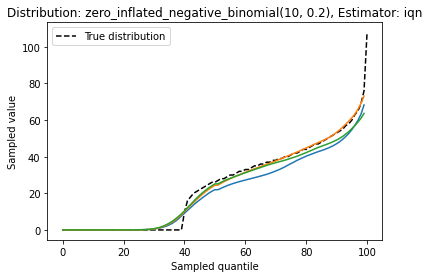

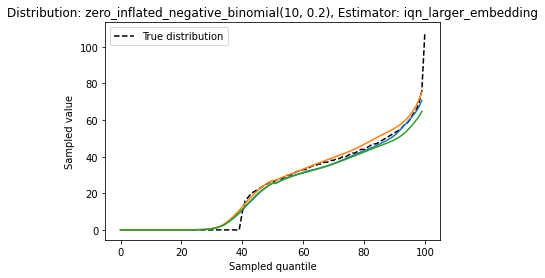

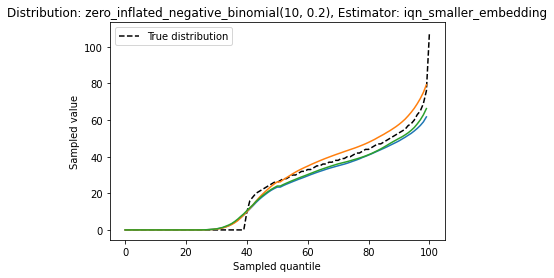

-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn


,mean,amin,amax
MASE,1.297913,1.287986,1.304836
sMAPE,1.107227,1.073120,1.145712
MSIS,5.396360,5.060412,5.736654
mean_wQuantileLoss,0.580080,0.577022,0.585566
wQuantileLoss[0.1],0.200104,0.200060,0.200179
wQuantileLoss[0.5],0.832366,0.831338,0.833707
wQuantileLoss[0.9],0.348431,0.339843,0.363990


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn_larger_embedding


,mean,amin,amax
MASE,1.308688,1.292290,1.333771
sMAPE,1.064532,1.046920,1.079215
MSIS,5.243153,5.171459,5.328819
mean_wQuantileLoss,0.582421,0.578906,0.585704
wQuantileLoss[0.1],0.200204,0.200034,0.200512
wQuantileLoss[0.5],0.839649,0.836675,0.841499
wQuantileLoss[0.9],0.345571,0.341195,0.352805


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn_smaller_embedding


,mean,amin,amax
MASE,1.302116,1.291380,1.321906
sMAPE,1.089589,1.066449,1.110444
MSIS,5.452403,5.249461,5.555013
mean_wQuantileLoss,0.583405,0.581586,0.585161
wQuantileLoss[0.1],0.200001,0.200000,0.200003
wQuantileLoss[0.5],0.838429,0.835326,0.842982
wQuantileLoss[0.9],0.345634,0.343724,0.347781


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.396667,0.396667,0.396667
Coverage[0.2],0.396667,0.396667,0.396667
Coverage[0.3],0.396778,0.396667,0.397000
Coverage[0.4],0.411111,0.406000,0.414667
Coverage[0.5],0.483111,0.461667,0.503667
Coverage[0.6],0.560111,0.513000,0.592000
Coverage[0.7],0.656778,0.593333,0.697000
Coverage[0.8],0.766667,0.737667,0.784333
Coverage[0.9],0.856222,0.822667,0.879667
wQuantileLoss[0.1],0.200104,0.200060,0.200179


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn_larger_embedding


,mean,amin,amax
Coverage[0.1],0.396667,0.396667,0.396667
Coverage[0.2],0.396667,0.396667,0.396667
Coverage[0.3],0.397556,0.397333,0.397667
Coverage[0.4],0.424222,0.421667,0.426333
Coverage[0.5],0.517111,0.499333,0.536667
Coverage[0.6],0.600222,0.576000,0.634667
Coverage[0.7],0.695556,0.662333,0.745333
Coverage[0.8],0.800889,0.773667,0.842667
Coverage[0.9],0.888111,0.872333,0.919667
wQuantileLoss[0.1],0.200204,0.200034,0.200512


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn_smaller_embedding


,mean,amin,amax
Coverage[0.1],0.396667,0.396667,0.396667
Coverage[0.2],0.396667,0.396667,0.396667
Coverage[0.3],0.397000,0.396667,0.397333
Coverage[0.4],0.415444,0.409000,0.419000
Coverage[0.5],0.500222,0.477000,0.528667
Coverage[0.6],0.601556,0.558667,0.659000
Coverage[0.7],0.701778,0.652333,0.769333
Coverage[0.8],0.787889,0.748333,0.849667
Coverage[0.9],0.886000,0.854667,0.929333
wQuantileLoss[0.1],0.200001,0.200000,0.200003


In [75]:
compare_trainings(negative_binomial_results, negative_bin_dataset_references)

In [69]:
gm_dataset_references = {
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
}   


distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Real"),
    'iqn_old_architecture': ExperimentalImplicitQuantileOutput(
        output_domain="Real", 
        implicit_quantile_module_cls=OldIqnModule
    )
}

create_datasets(gm_dataset_references)
gaussian_mixture_results = run_all_trainings(distr_outputs, gm_dataset_references, META_DATA)

15it [00:00, 21.81it/s, avg_epoch_loss=1.02, epoch=0]
15it [00:00, 21.03it/s, avg_epoch_loss=0.977, epoch=1]
15it [00:00, 22.33it/s, avg_epoch_loss=0.957, epoch=2]
15it [00:00, 17.73it/s, avg_epoch_loss=0.967, epoch=3]
15it [00:00, 21.07it/s, avg_epoch_loss=0.904, epoch=4]
15it [00:00, 17.70it/s, avg_epoch_loss=0.76, epoch=5] 
15it [00:00, 20.05it/s, avg_epoch_loss=0.732, epoch=6]
15it [00:00, 17.79it/s, avg_epoch_loss=0.708, epoch=7]
15it [00:00, 19.00it/s, avg_epoch_loss=0.691, epoch=8]
15it [00:00, 19.85it/s, avg_epoch_loss=0.699, epoch=9]
15it [00:00, 19.87it/s, avg_epoch_loss=0.695, epoch=10]
15it [00:00, 18.20it/s, avg_epoch_loss=0.686, epoch=11]
15it [00:00, 17.80it/s, avg_epoch_loss=0.682, epoch=12]
15it [00:00, 21.47it/s, avg_epoch_loss=0.678, epoch=13]
15it [00:00, 18.30it/s, avg_epoch_loss=0.692, epoch=14]
15it [00:00, 21.77it/s, avg_epoch_loss=0.681, epoch=15]
15it [00:00, 16.76it/s, avg_epoch_loss=0.681, epoch=16]
15it [00:00, 20.38it/s, avg_epoch_loss=0.684, epoch=17]
15i

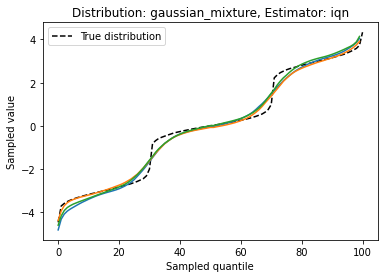

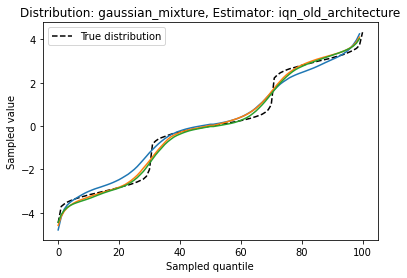

-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn


,mean,amin,amax
MASE,1.012376,1.009990,1.015164
sMAPE,1.758372,1.752596,1.762452
MSIS,4.225200,4.143917,4.282020
mean_wQuantileLoss,0.772570,0.770480,0.775718
wQuantileLoss[0.1],0.364629,0.359574,0.368181
wQuantileLoss[0.5],1.004466,1.003660,1.005665
wQuantileLoss[0.9],0.362120,0.360510,0.364691


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn_old_architecture


,mean,amin,amax
MASE,1.011674,1.008244,1.014371
sMAPE,1.784851,1.775527,1.791542
MSIS,4.333457,4.164123,4.576963
mean_wQuantileLoss,0.774139,0.773171,0.775615
wQuantileLoss[0.1],0.369613,0.362197,0.381676
wQuantileLoss[0.5],1.003688,1.002203,1.005181
wQuantileLoss[0.9],0.367894,0.360977,0.380743


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.073222,0.056667,0.102333
Coverage[0.2],0.186889,0.171000,0.215667
Coverage[0.3],0.293556,0.287667,0.303000
Coverage[0.4],0.384333,0.384333,0.384333
Coverage[0.5],0.489778,0.475667,0.505000
Coverage[0.6],0.593222,0.570333,0.610667
Coverage[0.7],0.693778,0.683333,0.699667
Coverage[0.8],0.799000,0.777333,0.826000
Coverage[0.9],0.909111,0.887667,0.931333
wQuantileLoss[0.1],0.364629,0.359574,0.368181


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn_old_architecture


,mean,amin,amax
Coverage[0.1],0.098111,0.065333,0.150333
Coverage[0.2],0.207778,0.188667,0.243000
Coverage[0.3],0.300667,0.288000,0.315000
Coverage[0.4],0.408444,0.387000,0.426667
Coverage[0.5],0.509222,0.491667,0.522667
Coverage[0.6],0.602111,0.580333,0.621000
Coverage[0.7],0.699333,0.694333,0.708000
Coverage[0.8],0.781000,0.745000,0.814000
Coverage[0.9],0.904333,0.861667,0.926333
wQuantileLoss[0.1],0.369613,0.362197,0.381676


In [70]:
compare_trainings(gaussian_mixture_results, gm_dataset_references)

In [ ]:
class OldQuantileLayer(QuantileLayer):
    def __init__(self, num_output):
        super(OldQuantileLayer, self).__init__()
        self.n_cos_embedding = 64
        self.num_output = num_output
        self.output_layer = nn.Sequential(
            nn.Linear(self.n_cos_embedding, num_output),
            nn.ReLU(),
        )
        
class OldIqnModule(ImplicitQuantileModule):
    def __init__(self, in_features, output_domain_cls):
        super(OldIqnModule, self).__init__(in_features)
        self.in_features = in_features
        self.quantile_layer = OldQuantileLayer(in_features)
        self.output_layer = nn.Sequential(
            nn.Linear(in_features, 1),
            output_domain_cls(),
        )


distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Real"),
    'iqn_old_architecture': ExperimentalImplicitQuantileOutput(
        output_domain="Real", 
        implicit_quantile_module_cls=OldIqnModule
    )
}


test_results = run_all_trainings(distr_outputs, gm_dataset_references, META_DATA)
compare_trainings(test_results, gm_dataset_references)